<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/deeplearning/image classification/Tool Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

2025-12-02 12:18:02.747301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/train", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 249 files belonging to 10 classes.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/validation", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 83 files belonging to 10 classes.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 86 files belonging to 10 classes.


In [5]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

2025-12-02 12:18:11.918467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


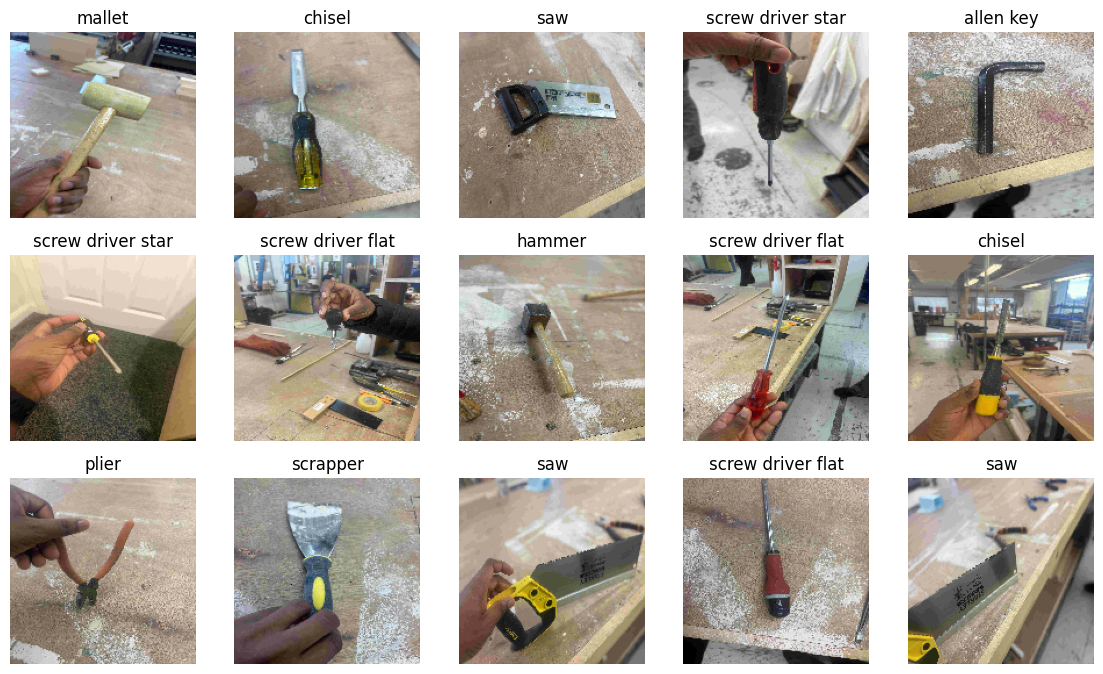

In [6]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 8
Number of validation batches: 3
Number of test batches: 3


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Because I don't have a large image dataset, I'm to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduces overfitting

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomContrast(factor=0.2)
])

2025-12-02 12:18:15.026266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


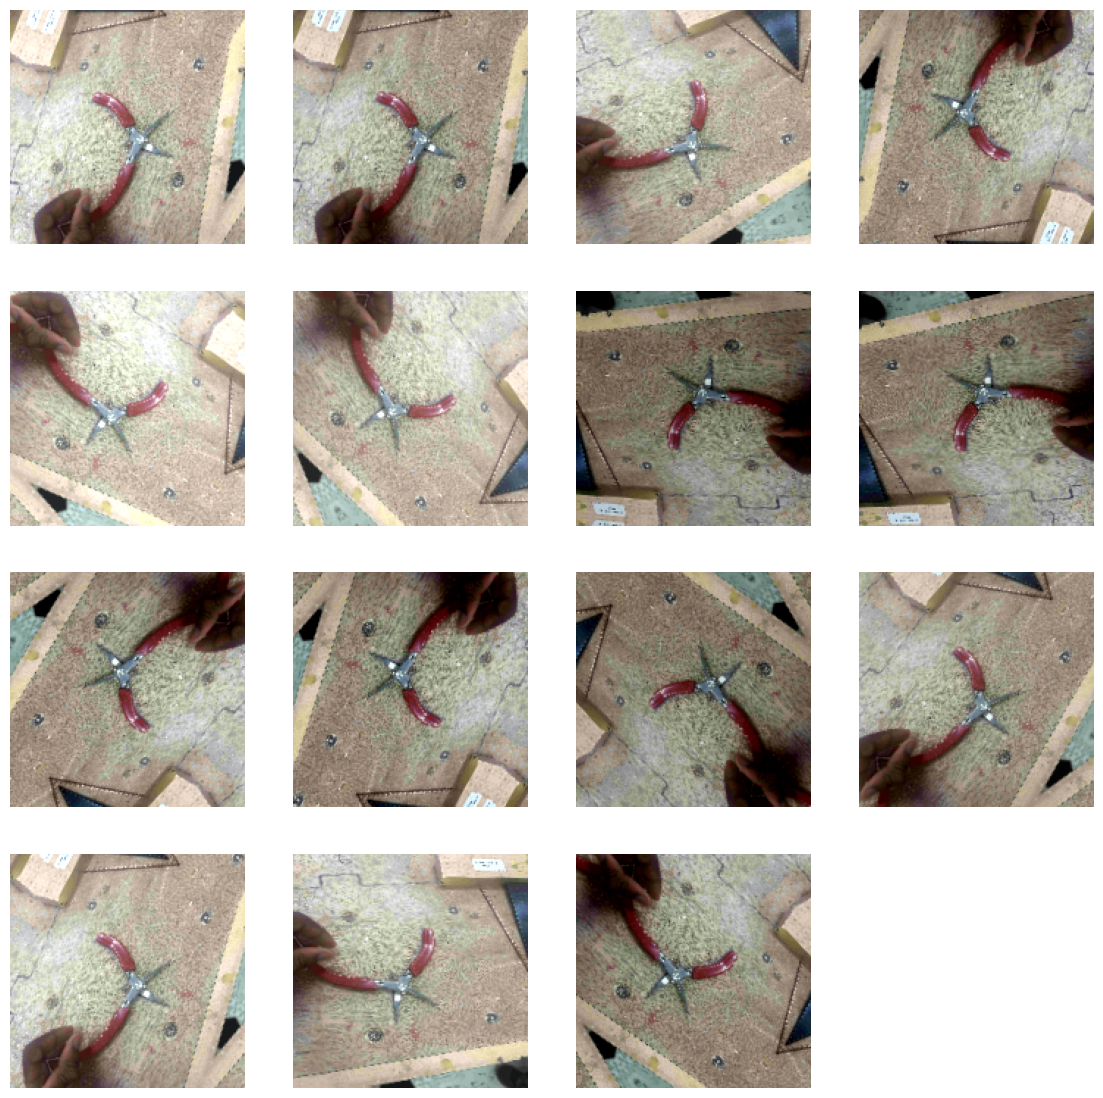

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [11]:
def classifer_model(is_mobilenet, base_learning_rate, fine_tune=False):

    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, _ = next(iter(train_ds))
    feature_batch = base_model(image_batch)

    network_depth = len(base_model.layers)

    print("Number of layers in the base model: ", network_depth)

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = 30 * 100 // network_depth # fine tune 30% of the network
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
          layer.trainable = False
    else:
        base_model.trainable = False # Freeze all the layers of the model
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    print("Trainable Parameters: ", len(model.trainable_variables))

    return model

        

### Model Test

In [12]:
learning_rate = 0.0001
epochs = 100
mobile_netv2 = classifer_model(True, learning_rate)
inception_v3 = classifer_model(False, learning_rate)
mobile_netv2_finetune = classifer_model(True, learning_rate, True)
inception_v3_finetune = classifer_model(False, learning_rate, True)

Number of layers in the base model:  154
Number of layers in the base model:  311
Number of layers in the base model:  154
Number of layers in the base model:  311


In [13]:
history_mobile_netv2 = mobile_netv2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0924 - loss: 3.0317 - val_accuracy: 0.0602 - val_loss: 2.7406
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1365 - loss: 2.8583 - val_accuracy: 0.0482 - val_loss: 2.6353
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1205 - loss: 2.8474 - val_accuracy: 0.0723 - val_loss: 2.5654
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1245 - loss: 2.7470 - val_accuracy: 0.0723 - val_loss: 2.5092
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1647 - loss: 2.5593 - val_accuracy: 0.0723 - val_loss: 2.4501
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1807 - loss: 2.4420 - val_accuracy: 0.0843 - val_loss: 2.3952
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1847 - loss: 2.4977 - val_accuracy: 0.1084 - val_loss: 2.3451
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1847 - loss: 2.4055 - val_accuracy: 0.1084 - val_loss: 2.2918


In [14]:
history_inception_v3 = inception_v3.fit(train_ds, epochs=epochs, validation_data=val_ds,)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.0884 - loss: 4.1837 - val_accuracy: 0.0964 - val_loss: 3.3649
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1325 - loss: 3.4684 - val_accuracy: 0.0964 - val_loss: 3.0687
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1446 - loss: 3.2428 - val_accuracy: 0.1205 - val_loss: 2.9739
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1325 - loss: 3.2186 - val_accuracy: 0.1205 - val_loss: 2.8689
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1446 - loss: 3.3514 - val_accuracy: 0.1325 - val_loss: 2.7509
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1928 - loss: 2.9178 - val_accuracy: 0.1205 - val_loss: 2.6553
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1727 - loss: 2.8898 - val_accuracy: 0.1325 - val_loss: 2.5729
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2329 - loss: 2.6203 - val_accuracy: 0.1566 - val_loss: 2.4799


In [15]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

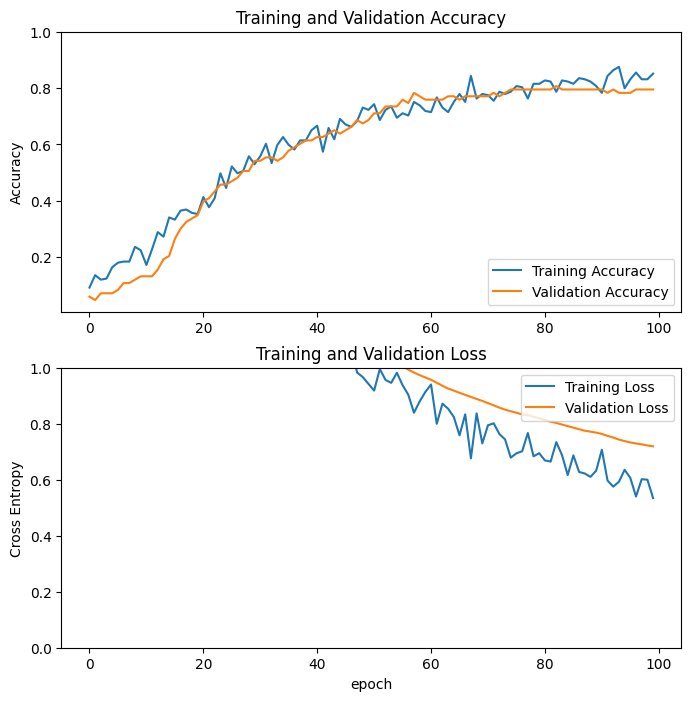

In [16]:
plot_train_val_stat(history_mobile_netv2)

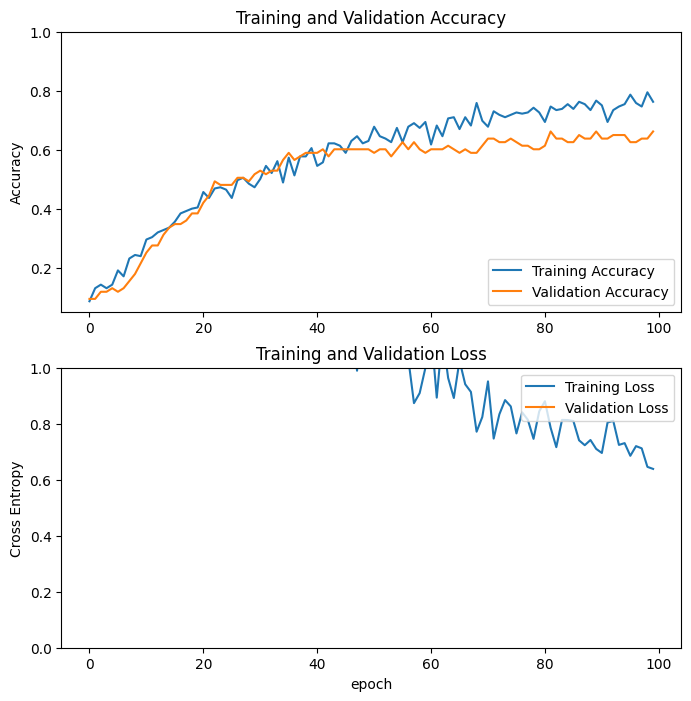

In [17]:
plot_train_val_stat(history_inception_v3)

In [18]:
def make_predictions(model):

    y_true = []
    y_pred = []
    image_features = []

    model.evaluate(test_ds)

    # Iterate over the test dataset
    for images, labels in test_ds:
        
        # Get True Labels
        y_true.extend(labels.numpy()) # Use .numpy() to extract data
       
        # Get Predictions
        predictions = model.predict(images)
        # Convert prediction probabilities to class index (e.g., [0.1, 0.9] -> 1)
        y_pred.extend(np.argmax(predictions, axis=1))

        # Saved the images
        image_features.extend(images)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cr = classification_report(y_true, y_pred, target_names=class_names)

    print(cr)

    # Display the matrix using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') 
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title('Confusion Matrix for Image Dataset')
    plt.show()

    return y_true, y_pred, image_features



In [19]:
def show_images():
    plt.figure(figsize=(15, 15))
    for i in range(15):
       ax = plt.subplot(5, 5, i + 1)
       plt.imshow(image_batch[i].astype("uint8"))
       plt.title(class_names[prediction_val[i]])
       plt.axis("off")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - accuracy: 0.7791 - loss: 0.7875
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                   precision    recall  f1-score   support

        allen key       0.86      0.75      0.80         8
           chisel       0.75      0.75      0.75         8
           hammer       0.43      0.38      0.40         8
           mallet       0.82      0.90      0.86        10
            plier       1.00      0.90      0.95        10
              saw       0.91      1.00      0.95        10
         scrapper       0.83      1.00      0.91        10
screw driver flat       0.50      0.29      0.36         7
screw driver star       0.58      1.00      0.74         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.78        86
        macro avg       0.77      0.76      0.75        86
     weighted avg       0.78      0.78      0.7

2025-12-02 13:00:34.237376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


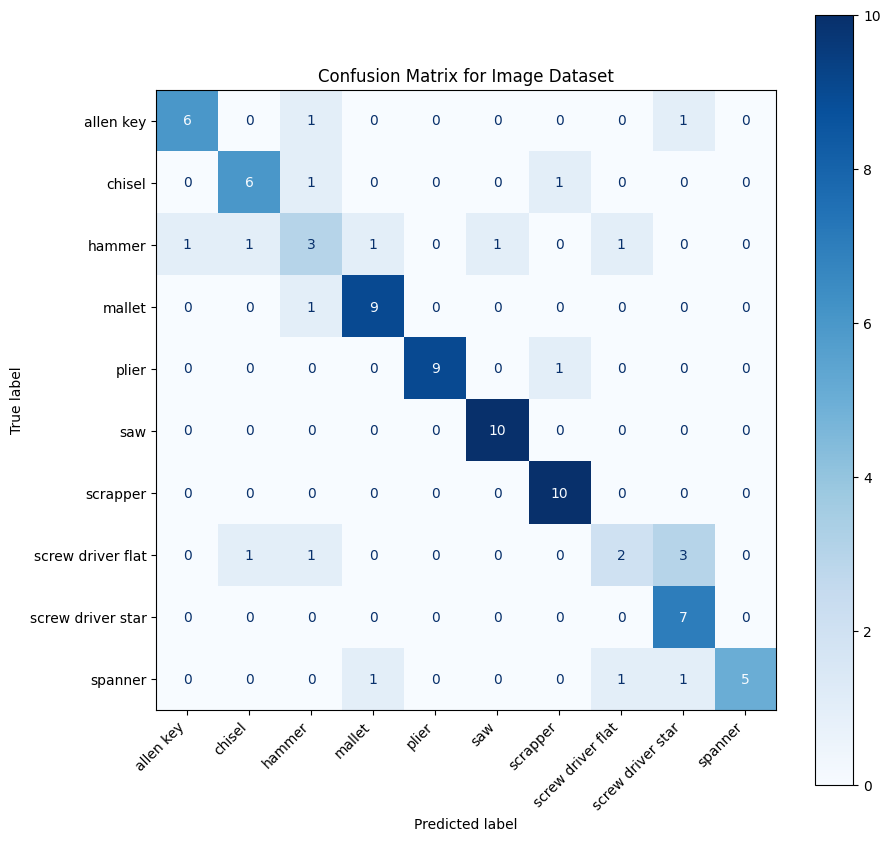

In [20]:
mobile_netv2_pred = make_predictions(mobile_netv2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.7209 - loss: 0.7490
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
                   precision    recall  f1-score   support

        allen key       0.88      0.88      0.88         8
           chisel       1.00      0.50      0.67         8
           hammer       0.46      0.75      0.57         8
           mallet       0.45      0.50      0.48        10
            plier       0.90      0.90      0.90        10
              saw       1.00      0.90      0.95        10
         scrapper       0.89      0.80      0.84        10
screw driver flat       0.33      0.29      0.31         7
screw driver star       0.86      0.86      0.86         7
          spanner       0.67      0.75      0.71         8

         accuracy                           0.72        86
        macro avg       0.74      0.71      0.71        86
     weighted avg       0.75      0.72   

2025-12-02 14:40:59.200837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


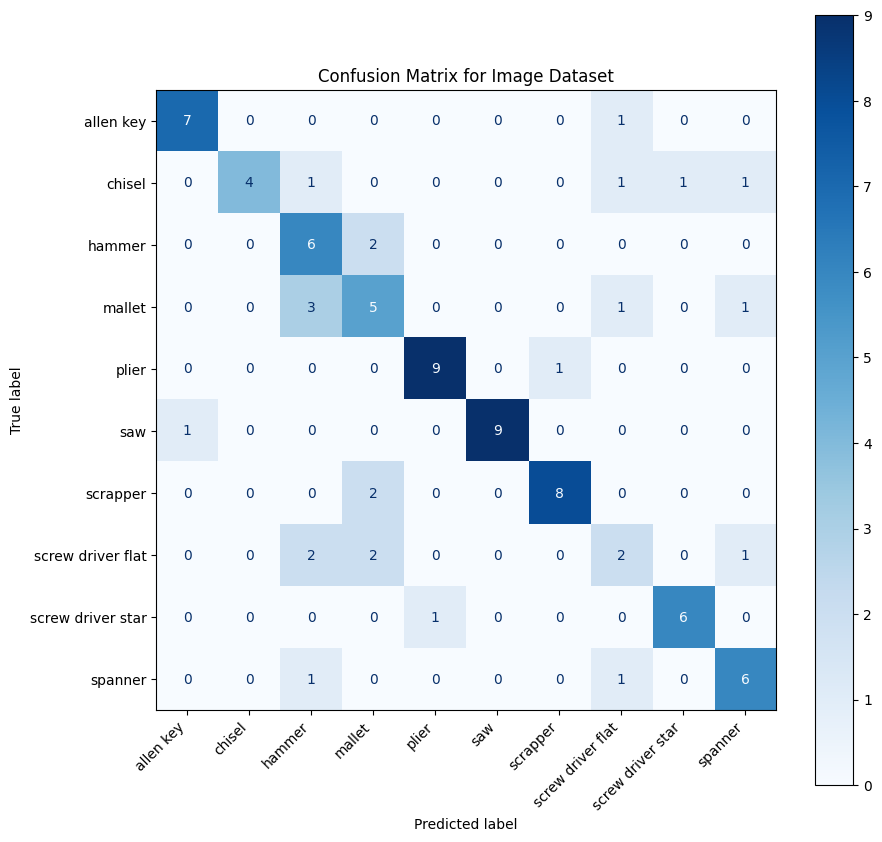

In [26]:
inception_netv3_pred = make_predictions(inception_v3)

In [22]:
history_mobile_netv2_finetune = mobile_netv2_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds, )

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.1526 - loss: 2.7346 - val_accuracy: 0.1807 - val_loss: 2.6378
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3092 - loss: 2.0630 - val_accuracy: 0.3855 - val_loss: 2.0129
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5181 - loss: 1.5568 - val_accuracy: 0.5422 - val_loss: 1.5963
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6867 - loss: 1.0902 - val_accuracy: 0.5904 - val_loss: 1.3063
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7590 - loss: 0.8973 - val_accuracy: 0.6747 - val_loss: 1.0781
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8072 - loss: 0.7007 - val_accuracy: 0.7108 - val_loss: 0.9151
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8715 - loss: 0.6163 - val_accuracy: 0.7349 - val_loss: 0.8032
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8916 - loss: 0.5255 - val_accuracy: 0.7229 - val_loss: 0.7450


In [23]:
history_inception_v3_finetune = inception_v3_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.1807 - loss: 2.3170 - val_accuracy: 0.2169 - val_loss: 2.4527
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.3896 - loss: 1.8099 - val_accuracy: 0.4096 - val_loss: 2.3072
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.6305 - loss: 1.3383 - val_accuracy: 0.4699 - val_loss: 2.2859
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.6867 - loss: 1.1252 - val_accuracy: 0.5301 - val_loss: 1.8099
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8193 - loss: 0.8170 - val_accuracy: 0.6265 - val_loss: 1.3278
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8193 - loss: 0.6872 - val_accuracy: 0.6988 - val_loss: 1.0846
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8554 - loss: 0.5604 - val_accuracy: 0.7229 - val_loss: 0.9763
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9036 - loss: 0.4543 - val_accuracy: 0.7711 - val_loss: 0.8685


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.9302 - loss: 0.2418
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                   precision    recall  f1-score   support

        allen key       0.80      1.00      0.89         8
           chisel       1.00      0.88      0.93         8
           hammer       1.00      1.00      1.00         8
           mallet       0.91      1.00      0.95        10
            plier       1.00      1.00      1.00        10
              saw       1.00      1.00      1.00        10
         scrapper       1.00      1.00      1.00        10
screw driver flat       1.00      0.71      0.83         7
screw driver star       0.70      1.00      0.82         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.93        86
        macro avg       0.94      0.92      0.92        86
     weighted avg       0.95      0.93      0.9

2025-12-02 14:40:34.612924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


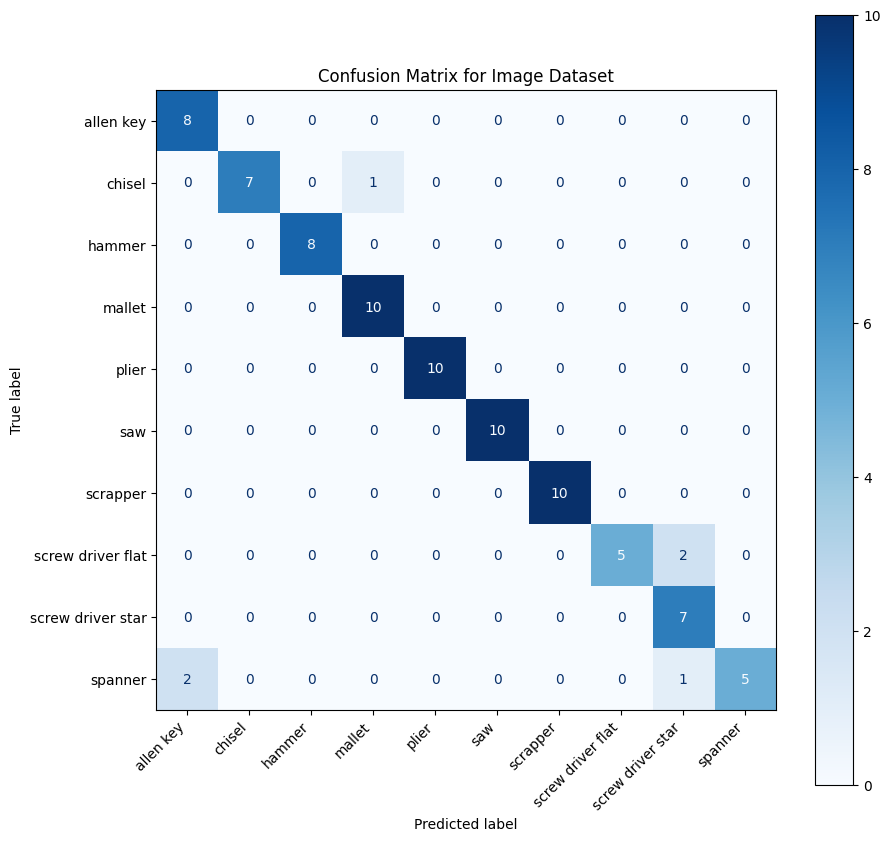

([4,
  8,
  2,
  5,
  4,
  4,
  3,
  6,
  7,
  4,
  8,
  1,
  5,
  5,
  6,
  7,
  0,
  9,
  7,
  8,
  4,
  8,
  0,
  4,
  7,
  2,
  2,
  3,
  0,
  9,
  6,
  6,
  3,
  4,
  6,
  4,
  6,
  7,
  1,
  6,
  5,
  0,
  3,
  7,
  3,
  9,
  5,
  9,
  8,
  1,
  1,
  1,
  5,
  6,
  4,
  0,
  2,
  7,
  5,
  2,
  3,
  6,
  2,
  8,
  5,
  3,
  9,
  0,
  9,
  0,
  5,
  1,
  3,
  9,
  6,
  8,
  1,
  0,
  5,
  9,
  3,
  2,
  3,
  4,
  2,
  1],
 [4,
  8,
  2,
  5,
  4,
  4,
  3,
  6,
  7,
  4,
  8,
  1,
  5,
  5,
  6,
  7,
  0,
  0,
  8,
  8,
  4,
  8,
  0,
  4,
  8,
  2,
  2,
  3,
  0,
  9,
  6,
  6,
  3,
  4,
  6,
  4,
  6,
  7,
  1,
  6,
  5,
  0,
  3,
  7,
  3,
  9,
  5,
  9,
  8,
  1,
  1,
  3,
  5,
  6,
  4,
  0,
  2,
  7,
  5,
  2,
  3,
  6,
  2,
  8,
  5,
  3,
  8,
  0,
  9,
  0,
  5,
  1,
  3,
  9,
  6,
  8,
  1,
  0,
  5,
  0,
  3,
  2,
  3,
  4,
  2,
  1],
 [<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
  array([[[188.      , 188.      , 188.      ],
          [194.95    , 194.95    

In [24]:
make_predictions(mobile_netv2_finetune)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 879ms/step - accuracy: 0.9070 - loss: 0.2722
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                   precision    recall  f1-score   support

        allen key       0.80      1.00      0.89         8
           chisel       1.00      0.88      0.93         8
           hammer       0.88      0.88      0.88         8
           mallet       1.00      0.70      0.82        10
            plier       0.91      1.00      0.95        10
              saw       1.00      1.00      1.00        10
         scrapper       1.00      1.00      1.00        10
screw driver flat       0.75      0.86      0.80         7
screw driver star       0.88      1.00      0.93         7
          spanner       0.86      0.75      0.80         8

         accuracy                           0.91        86
        macro avg       0.91      0.91      0.90        86
     weighted avg       0.92      0.91      0.9

2025-12-02 14:40:50.106957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


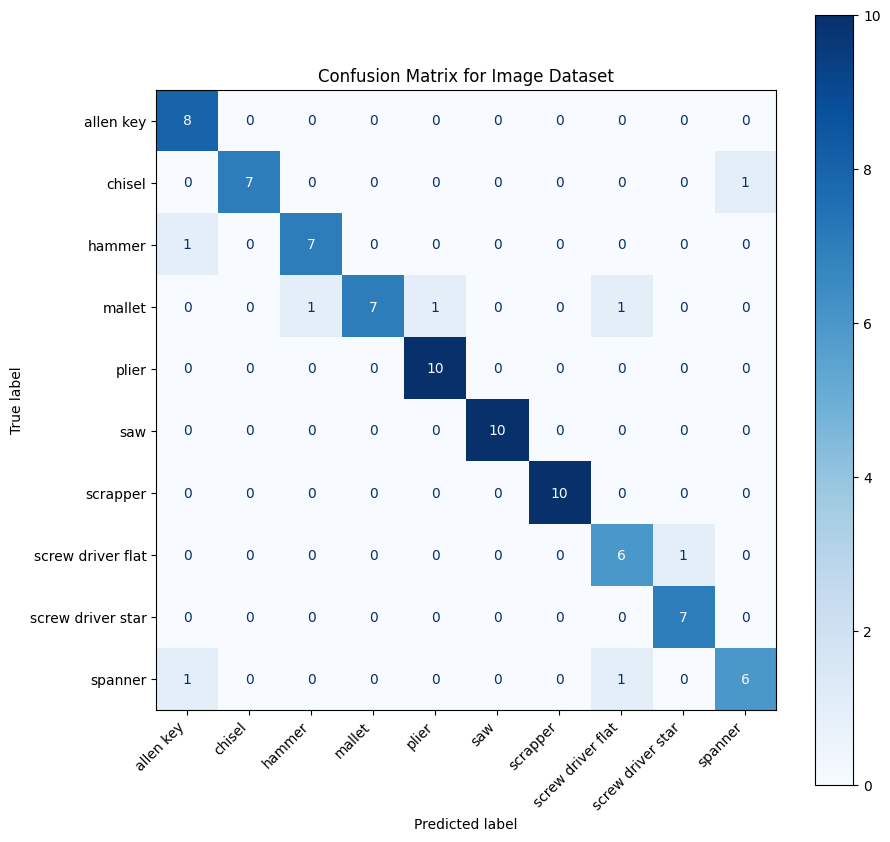

([5,
  5,
  6,
  5,
  2,
  4,
  4,
  0,
  6,
  3,
  7,
  4,
  9,
  1,
  9,
  6,
  6,
  2,
  3,
  4,
  3,
  0,
  1,
  6,
  7,
  3,
  4,
  6,
  0,
  9,
  6,
  1,
  9,
  6,
  2,
  3,
  8,
  5,
  8,
  0,
  7,
  1,
  8,
  5,
  5,
  1,
  3,
  7,
  7,
  5,
  3,
  5,
  3,
  4,
  2,
  8,
  1,
  4,
  4,
  9,
  1,
  2,
  2,
  8,
  6,
  7,
  0,
  6,
  0,
  4,
  3,
  2,
  8,
  5,
  9,
  9,
  5,
  9,
  0,
  0,
  4,
  2,
  8,
  3,
  7,
  1],
 [5,
  5,
  6,
  5,
  2,
  4,
  4,
  0,
  6,
  3,
  7,
  4,
  9,
  9,
  9,
  6,
  6,
  2,
  2,
  4,
  3,
  0,
  1,
  6,
  8,
  3,
  4,
  6,
  0,
  9,
  6,
  1,
  7,
  6,
  2,
  3,
  8,
  5,
  8,
  0,
  7,
  1,
  8,
  5,
  5,
  1,
  7,
  7,
  7,
  5,
  4,
  5,
  3,
  4,
  2,
  8,
  1,
  4,
  4,
  0,
  1,
  0,
  2,
  8,
  6,
  7,
  0,
  6,
  0,
  4,
  3,
  2,
  8,
  5,
  9,
  9,
  5,
  9,
  0,
  0,
  4,
  2,
  8,
  3,
  7,
  1],
 [<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
  array([[[132.      , 115.      ,  99.      ],
          [132.      , 115.      

In [25]:
make_predictions(inception_v3_finetune)